# Qutrit Quantum Kernel with Classical Support Vector Machine (SVM) for XOR Dataset

In this Jupyter notebook, I demonstrate the utilization of a quantum kernel in conjunction with a classical Support Vector Machine (SVM) approach to tackle the XOR dataset. The XOR dataset is a binary classification problem that consists of data points arranged in a manner that forms an exclusive OR (XOR) relationship between the classes, posing a challenge for linear classifiers.

I'll utilize custom functions, to construct the quantum kernel. For the classical SVM part, I'll rely on the popular scikit-learn library, which provides various machine learning tools and models, including SVM. The steps involved in this implementation include data preprocessing, quantum feature mapping, classical SVM training, and evaluation.

Initially, importing the necessary libraries.

In [1]:
import numpy as np
import torch
import warnings
from scipy.linalg import expm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from matplotlib.ticker import MaxNLocator # needed for integer only on axis
from matplotlib.lines import Line2D # for creating the custom legend
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import make_moons, make_circles, make_swiss_roll
from matplotlib.colors import ListedColormap
plt.style.use('ipynb')

#### Qutrits

Defining the qutrits that have three possible states, denoted as |0⟩, |1⟩, and |2⟩. 

In [3]:
# Define the qutrit states as column vectors
q0 = np.array([[1], [0], [0]])
q1 = np.array([[0], [1], [0]])
q2 = np.array([[0], [0], [1]])

#### Gell-Mann Matrices

The generators of a qutrit are the operators that generate transformations on the qutrit states under some symmetry group. One common set of generators for a qutrit are the Gell-Mann matrices, which are a set of 8 Hermitian operators that span the space of 3x3 complex matrices:

$gm1 = |0⟩⟨1| + |1⟩⟨0| \\
gm2 = -i(|0⟩⟨1| - |1⟩⟨0|) \\
gm3 = |0⟩⟨0| - |1⟩⟨1| \\
gm4 = |0⟩⟨2| + |2⟩⟨0| \\
gm5 = -i(|0⟩⟨2| - |2⟩⟨0|) \\
gm6 = |1⟩⟨2| + |2⟩⟨1| \\
gm7 = -i(|1⟩⟨2| - |2⟩⟨1|) \\
gm8 = 1/√3 (|0⟩⟨0| + |1⟩⟨1| - 2|2⟩⟨2|)$

These generators satisfy the commutation relations of the SU(3) Lie algebra, which is the symmetry group of the qutrit. The Gell-Mann matrices can be used to construct any unitary transformation on the qutrit, making them a useful tool for analyzing the behavior of qutrit systems in quantum mechanics.

In [4]:
# Define the Gell-Mann matrices
gm1 = np.kron(q0, q1.T) + np.kron(q1, q0.T)
gm2 = -1j * (np.kron(q0, q1.T) - np.kron(q1, q0.T))
gm3 = np.kron(q0, q0.T) - np.kron(q1, q1.T)
gm4 = np.kron(q0, q2.T) + np.kron(q2, q0.T)
gm5 = -1j * (np.kron(q0, q2.T) - np.kron(q2, q0.T))
gm6 = np.kron(q1, q2.T) + np.kron(q2, q1.T)
gm7 = -1j * (np.kron(q1, q2.T) - np.kron(q2, q1.T))
gm8 = 1/np.sqrt(3) * (np.kron(q0, q0.T) + np.kron(q1, q1.T) - 2*np.kron(q2, q2.T))

# Collect the Glenn-Mann matrices in a list
generators = [gm1, gm2, gm3, gm4, gm5, gm6, gm7, gm8]

# Print Glenn-Mann 8
print(gm8)

[[ 0.57735027  0.          0.        ]
 [ 0.          0.57735027  0.        ]
 [ 0.          0.         -1.15470054]]


#### Generalised Hadamard for Qutrits

Then defining the Hadamard operator for qutrits.

In [5]:
# Define the Hadamard operator for qutrits
H = (1/np.sqrt(3)) * np.array([[1, 1, 1], [1, np.exp(2j*np.pi/3), np.exp(-2j*np.pi/3)], [1, np.exp(-2j*np.pi/3), np.exp(2j*np.pi/3)]])

# Print the Hadamard operator
print("Hadamard operator for qutrits:")
print(H)

Hadamard operator for qutrits:
[[ 0.57735027+0.j   0.57735027+0.j   0.57735027+0.j ]
 [ 0.57735027+0.j  -0.28867513+0.5j -0.28867513-0.5j]
 [ 0.57735027+0.j  -0.28867513-0.5j -0.28867513+0.5j]]


### Quantum Kernel

The quantum kernel, an innovative extension of SVM, employs quantum feature maps to transform the input data into a higher-dimensional Hilbert space. By leveraging the principles of quantum computing, the quantum kernel can capture complex and non-linear relationships between data points, making it advantageous over conventional SVM kernels for datasets with intricate decision boundaries.

In [6]:
# Encoding four features on a qutrit
def encoding(vector):

    sum = 0
    for i in range(2):
        sum = sum + (1j * vector[i] * generators[i]) 
    
    sum += 1j*vector[0] * generators[3]
    sum += 1j*vector[1] * generators[4]

    return np.dot(expm(sum), q0)

Testing to see if the encoding works with a simple vector.

In [7]:
vector = np.array([6.34, 22.11], dtype=complex)
vector2 = np.array([-6.34, 22.11], dtype=complex)

# projector_2 = np.zeros((2**1, 2**1))
# projector_2[0, 0] = 1

print(encoding(vector))
print(encoding(vector2))
print("multi")
print(np.real(np.dot(encoding(vector).conj().T, encoding(vector2))**2))

[[ 0.44246407-4.72420620e-17j]
 [-0.60955832+1.74789676e-01j]
 [-0.60955832+1.74789676e-01j]]
[[ 0.44246407+4.72420620e-17j]
 [-0.60955832-1.74789676e-01j]
 [-0.60955832-1.74789676e-01j]]
multi
[[0.5888951]]


Defining the quantum kernel and checking that it works correctly.

In [8]:
def kernel(x1, x2):
    """The quantum kernel."""
    return np.real(np.dot(encoding(x1).conj().T, encoding(x2))**2)[0][0]

In [9]:
print(kernel(vector, vector2))

0.588895101671477


In [10]:
x = torch.tensor(kernel(vector, vector), requires_grad=True)
print(x)

tensor(1.0000, dtype=torch.float64, requires_grad=True)


In [11]:
def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

### XOR Dataset

The XOR dataset contains data points that are distributed in a way that forms an exclusive OR (XOR) relationship between the classes. As a result, traditional linear classifiers struggle to accurately classify this dataset. We'll generate synthetic data points and labels to simulate the XOR dataset and showcase the effectiveness of our quantum kernel combined with the classical SVM.

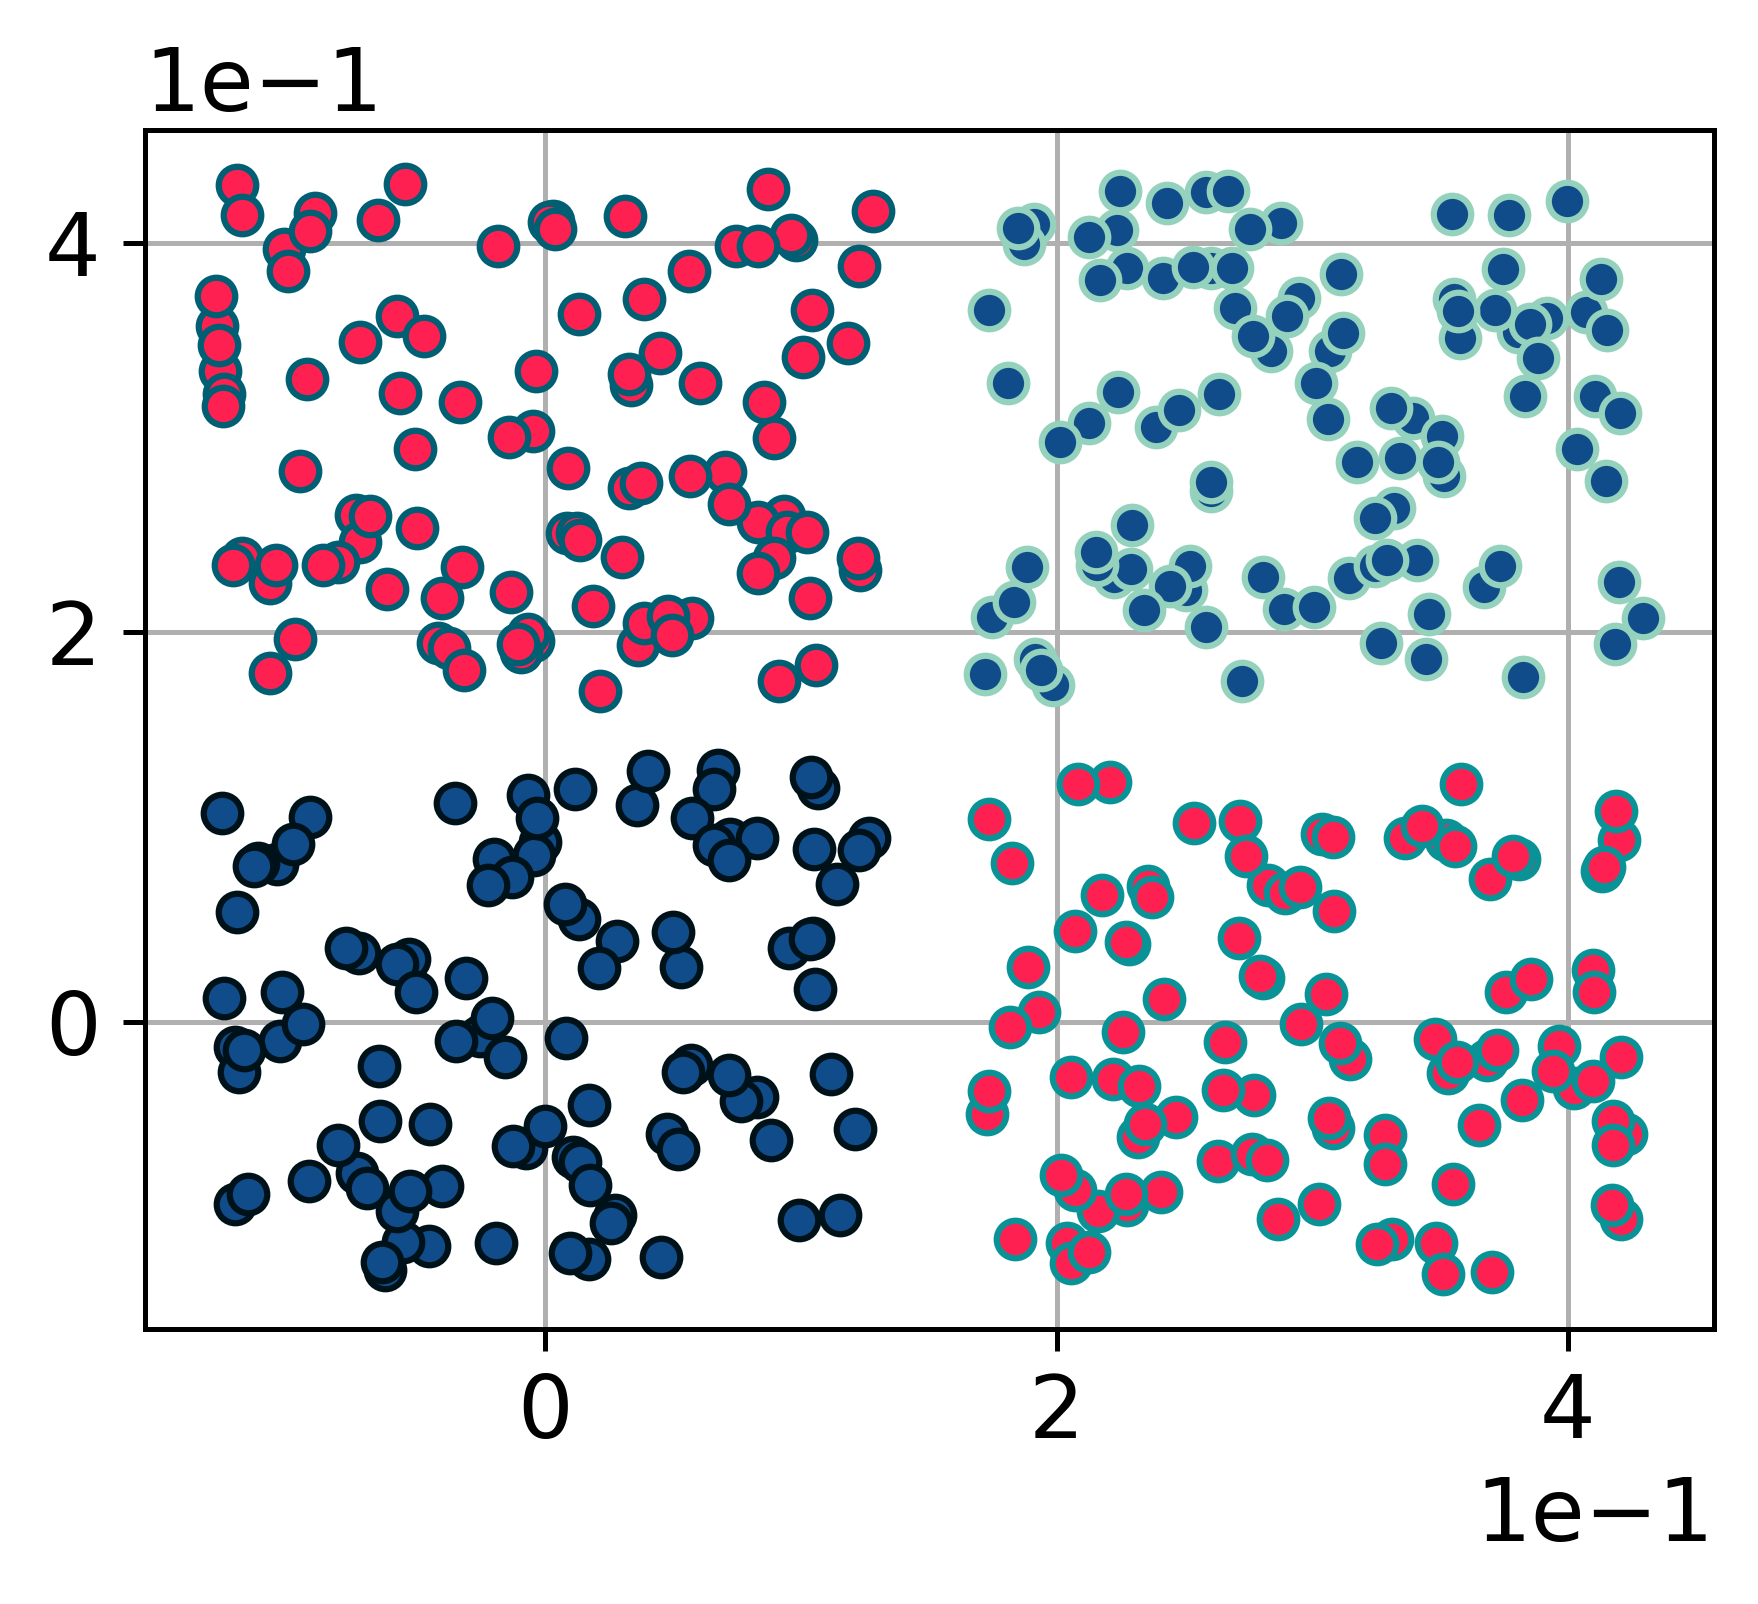

In [2]:

x = [[0, 0], [0, 0.3], [0.3, 0], [0.3, 0.3]]
space = 0.13
data = {}

for i in range(1, 5):
    data[i] = []
    for j in range(1, 101):
        data[i].append([x[i-1][0] + random.uniform(-space, space), x[i-1][1] + random.uniform(-space, space)])

label1_colour = '#104c89'
label2_colour = '#ff2052'

plt.plot(*zip(*data[1]), label="data[1]" , marker='o', linestyle='', markerfacecolor=label1_colour)
plt.plot(*zip(*data[2]), label="data[2]", marker='o', linestyle='', markerfacecolor=label2_colour)
plt.plot(*zip(*data[3]), label="data[3]", marker='o', linestyle='', markerfacecolor=label2_colour)
plt.plot(*zip(*data[4]), label="data[4]", marker='o', linestyle='', markerfacecolor=label1_colour)
plt.grid(True)
plt.show()

In [28]:
# Create the classes and concatenate on X
class_one = np.concatenate((np.array(data[1]), np.array(data[4])), axis=0)
class_two = np.concatenate((np.array(data[2]), np.array(data[3])), axis=0)
X = np.concatenate((class_one, class_two), axis=0)

y = np.zeros(200, dtype=int)
two = np.ones(200, dtype=int)
y = np.concatenate((y, two), axis=0)

# Scaling the inputs is important since the embedding we use is periodic
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

# Scaling the labels to -1, 1 is important for the definition of a hinge loss
y_scaled = 2 * (y - 0.5)

print('Shape of X:', X_scaled.shape)
print('Shape of y:', y_scaled.shape)
print('x[0] feature example: ', X_scaled[0])
print('y[0]: ', y_scaled[110])


Shape of X: (400, 2)
Shape of y: (400,)
x[0] feature example:  [-0.64526478 -0.31883408]
y[0]:  -1.0


Splitting the dataset into a training set and a test set with equal representation of the two classes in both sets, with the stratify parameter set to the target variable y.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.3, stratify=y_scaled, random_state=42)

# Use np.sum to count the number of instances of each class in both sets
print("Class counts in training set:", np.sum(y_train.shape))
print("Class counts in test set:", np.sum(y_test.shape))


Class counts in training set: 280
Class counts in test set: 120


### Classical Support Vector Machine (SVM)

The classical SVM is a powerful supervised learning algorithm that seeks to identify an optimal hyperplane to separate data points belonging to different classes while maximizing the margin between them.

In [20]:
svm = SVC(kernel=kernel_matrix).fit(X_train, y_train)

In [21]:
predictions = svm.predict(X_test)
accuracy_score(predictions, y_test)

0.9916666666666667

### Results

In [22]:
# To be printed better
y_pred = predictions
y_true = y_test
accuracy = accuracy_score(y_true, y_pred)* 100
f1 = f1_score(y_true, y_pred, average='macro')* 100
precision = precision_score(y_true, y_pred, average='macro')* 100
recall = recall_score(y_true, y_pred, average='macro')* 100

# Print the results
print("Evaluation Results")
print("_____________________________________________")
print(
            f"\nRecall: {recall:.2f}%"
            f"\nPrecision: {precision:.2f}%"
            f"\nAccuracy: {accuracy:.2f}%"
            f"\nMacro Averaged F1-score: {f1:.2f}%"
            )
print("_____________________________________________")

Evaluation Results
_____________________________________________

Recall: 99.17%
Precision: 99.18%
Accuracy: 99.17%
Macro Averaged F1-score: 99.17%
_____________________________________________


### Decision Boundaries

After training the model on the circles dataset, to visualize the classification results I will plot the decision boundaries.

In [27]:
def plot_decision_boundary2D(clf, X: np.ndarray, y: np.ndarray, classes: list, colormap: np.ndarray,
                             step: float = 0.1, prob_dot_scale: int = 40, prob_dot_scale_power: int = 3,
                             true_dot_size: int = 50, pad: float = 1.0,
                             prob_values: list = [0.4, 0.6, 0.8, 1.0]) -> None:
    """
    Original work by @timothyvh on Twitter.
    Recreating an R ggplot decision boundary plotting in python using matplotlib. 
    Note that this only works for 2D plotting. The goal of this function is to present a 
    classifier's decision boundary in an easy to read, digestible way to ease
    communication and visualization of results. 
    
    Arguments:
    clf - the classifier we want to visualize the decision boundary for. This should work for any kind of relevant model.
    X - our data we want to plot. Note that since this is a 2D array, X should be 2-dimensional.
    y - the target labels for the data we want to plot
    classes - the names of the classes you are trying to identify, should be same shape as colormap
    colormap - the colors you want to use to indicate your different classes, should be same shape as classes
    step - mesh stepsize
    prob_dot_scale - modifier to scale the probability dots
    prob_dot_scale_power - exponential used to increase/decrease size of prob dots
    true_dot_size - size of the true labels
    pad - how much to "pad" around the true labels
    prob_values - list of probabilities to map the meshgrid predictions to

    Returns:
    None - This function will simply output a graph of the decision boundary
    """
    # Handling X data dimension issues. If X doesn't have enough dimensions, throw error. Too many, use first two dimensions.
    X_dim = X.shape[1]
    if X_dim < 2:
        raise Exception("Error: Not enough dimensions in input data. Data must be at least 2-dimensional.")
    elif X_dim > 2: 
        warnings.warn(f"Warning: input data was {X_dim} dimensional. Expected 2. Using first 2 dimensions provided.")
    
    # Change colormap to a numpy array if it isn't already (necessary to prevent scalar error)
    if not isinstance(colormap, np.ndarray):
        colormap = np.array(colormap)        
        
    # create the x0, x1 feature. This is only a 2D plot after all. 
    x0 = X[:,0]
    x1 = X[:,1]
    
    # create 1D arrays representing the range of probability data points
    x0_min, x0_max = np.round(x0.min())-pad, np.round(x0.max()+pad)
    x1_min, x1_max = np.round(x1.min())-pad, np.round(x1.max()+pad)    
    x0_axis_range = np.arange(x0_min,x0_max, step)
    x1_axis_range = np.arange(x1_min,x1_max, step)
    
    # create meshgrid between the two axis ranges
    xx0, xx1 = np.meshgrid(x0_axis_range, x1_axis_range)
    
    # put the xx in the same dimensional format as the original X
    xx = np.reshape(np.stack((xx0.ravel(),xx1.ravel()),axis=1),(-1,2))
    
    yy_hat = clf.predict(xx) # prediction of all the little dots
    yy_prob = clf.predict_proba(xx) # probability of each dot being 
                                    # the predicted color
    yy_size = np.max(yy_prob, axis=1)
    
    # make figure
    plt.style.use('seaborn-v0_8') # set style because it looks nice
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6), dpi=150)
    
    # plot all the little dots
    ax.scatter(xx[:,0], xx[:,1], c=colormap[yy_hat], alpha=0.4, s=prob_dot_scale*yy_size**prob_dot_scale_power, linewidths=0,)
    
    # plot the contours
    ax.contour(x0_axis_range, x1_axis_range, 
               np.reshape(yy_hat,(xx0.shape[0],-1)), 
               levels=3, linewidths=1, 
               colors=[colormap[0],colormap[1], colormap[1],])
 
    # plot the original x values.
    ax.scatter(x0, x1, c=colormap[y], s=true_dot_size, zorder=3, linewidths=0.7, edgecolor='k')
 
    # create legends - Not sure if these serve a purpose but I left them in just in case
    x_min, x_max = ax.get_xlim()
    y_min, y_max = ax.get_ylim()
 
    ax.set_ylabel(r"$x_1$")
    ax.set_xlabel(r"$x_0$")
    
    # set the aspect ratio to 1, for looks
    ax.set_aspect(1)
 
    # create class legend
    legend_class = []
    for class_id, color in zip(classes, colormap):
        legend_class.append(Line2D([0], [0], marker='o', label=class_id,ls='None',
                                   markerfacecolor=color, markersize=np.sqrt(true_dot_size), 
                                   markeredgecolor='k', markeredgewidth=0.7))
 
    # iterate over each of the probabilities to create prob legend
    legend_prob = []
    for prob in prob_values:
        legend_prob.append(Line2D([0], [0], marker='o', label=prob, ls='None', alpha=0.8,
                                  markerfacecolor='grey', 
                                  markersize=np.sqrt(prob_dot_scale*prob**prob_dot_scale_power), 
                                  markeredgecolor='k', markeredgewidth=0))
 
 
    legend1 = ax.legend(handles=legend_class, loc='center', 
                        bbox_to_anchor=(1.05, 0.35),
                        frameon=False, title='class')
 
    legend2 = ax.legend(handles=legend_prob, loc='center', 
                        bbox_to_anchor=(1.05, 0.65),
                        frameon=False, title='prob', )
 
    ax.add_artist(legend1) # add legend back after it disappears
 
    ax.set_yticks(np.arange(x1_min,x1_max, 1)) # I don't like the decimals
    ax.grid(False) # remove gridlines (inherited from 'seaborn-whitegrid' style)
 
    # only use integers for axis tick labels
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
 
    # remove first ticks from axis labels, for looks
    ax.set_xticks(ax.get_xticks()[1:-1])
    ax.set_yticks(np.arange(x1_min,x1_max, 1)[1:])
 
    plt.show()

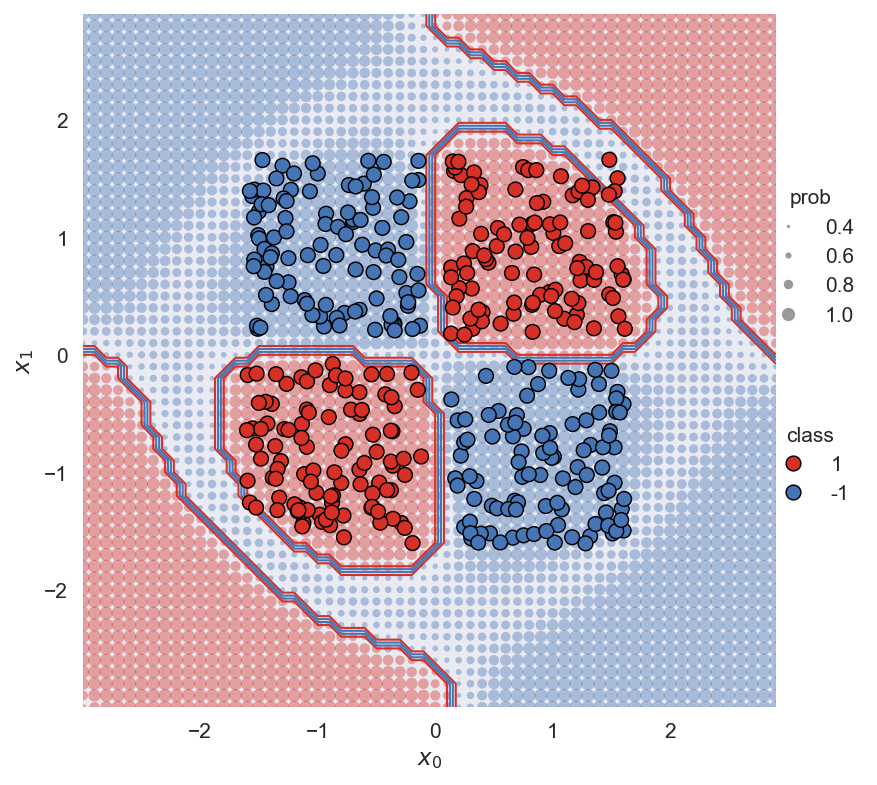

In [29]:
# Parameters for decision boundary plot
N_NEIGHBORS = 15
H = 0.1 
PROB_DOT_SCALE = 40
PROB_DOT_SCALE_POWER = 3
TRUE_DOT_SIZE = 50
PAD = 1.0

# Establish colors and colormap
redish = '#d73027'
blueish = '#4575b4'
colormap = np.array([redish,blueish])

# Establish classes
classes = ['1','-1']

# clf = neighbors.KNeighborsClassifier(N_NEIGHBORS, weights='uniform')
clf = SVC(kernel=kernel_matrix, probability=True).fit(X_scaled, y)
clf.fit(x, y)

# use function
plot_decision_boundary2D(clf, x, y.copy(), classes, colormap, 
                         step=H, 
                         prob_dot_scale=PROB_DOT_SCALE, 
                         prob_dot_scale_power=PROB_DOT_SCALE_POWER,
                         true_dot_size=TRUE_DOT_SIZE, 
                         pad=PAD,)